In [1]:
import os
import imgaug
import skimage as ski
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
%matplotlib inline

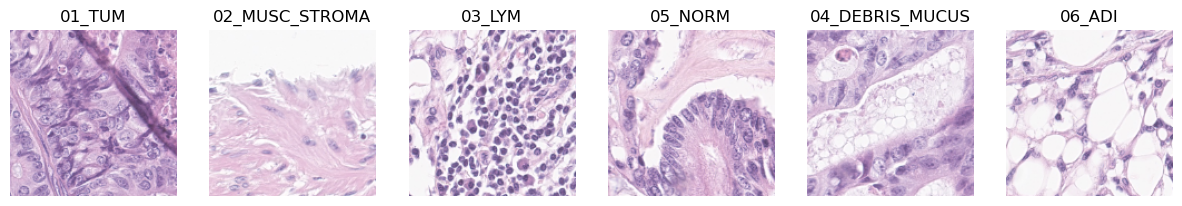

In [4]:
parent_dir = '../experiment_design/imgs'
subfolders = [f.path for f in os.scandir(parent_dir) if f.is_dir()]

image_list = []
image_name = []

for subfolder in subfolders:
    files = sorted(os.listdir(subfolder))
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    if image_files:
        # Load the first image in the subfolder
        img_path = os.path.join(subfolder, image_files[0])
        # print(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_list.append(img)
        image_name.append(img_path)

fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(image_list[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
# plt.title('original image')
plt.savefig('./original image.jpg')
plt.show()


Adding artificial noise

In [6]:
import numpy as np
import cv2
import imgaug as ia
import imgaug.augmenters as iaa

In [7]:
image_list[0].shape

(150, 150, 3)

In [8]:
noise_seq = iaa.Sequential([
    gaussian_noise := iaa.imgcorruptlike.GaussianNoise(severity=1)
])
# gaussian_noise = iaa.imgcorruptlike.GaussianNoise(severity=2)
noise_img_list_sli = [noise_seq(image = image) for image in image_list]

fig, axes = plt.subplots(1, len(noise_img_list_sli), figsize=(15, 5))
fig.suptitle("Gaussian Noise (slight) Augmented Images")
for i, ax in enumerate(axes):
    ax.imshow(noise_img_list_sli[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
# plt.savefig('./slight gaussian noise.jpg')
plt.show()

AssertionError: Parameter 'severity' is outside of the expected value range (1.0000 <= x <= 5.0000)

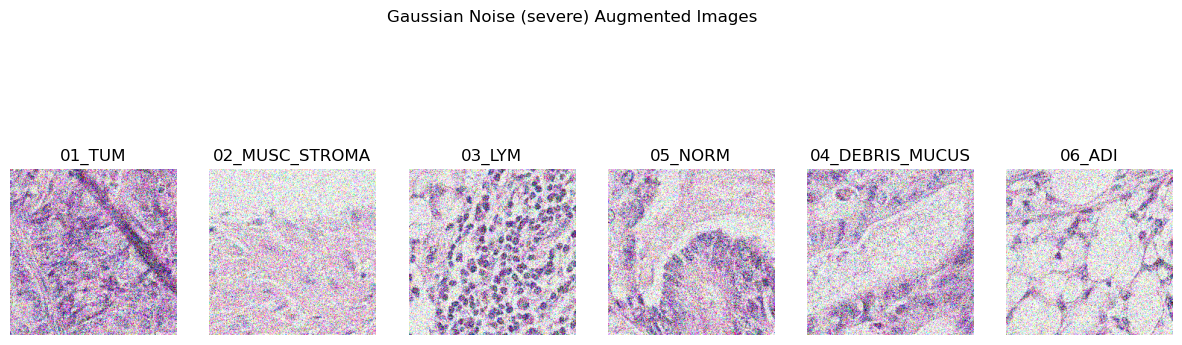

In [6]:
noise_seq = iaa.Sequential([
    gaussian_noise := iaa.imgcorruptlike.GaussianNoise(severity=4)
])
# gaussian_noise = iaa.imgcorruptlike.GaussianNoise(severity=2)
noise_img_list_ser = [noise_seq(image = image) for image in image_list]

fig, axes = plt.subplots(1, len(noise_img_list_ser), figsize=(15, 5))
fig.suptitle("Gaussian Noise (severe) Augmented Images")
for i, ax in enumerate(axes):
    ax.imshow(noise_img_list_ser[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
plt.savefig('./severe gaussian noise.jpg')
plt.show()

Image denoising by wavelet transformation

In [10]:
from skimage.restoration import denoise_wavelet, estimate_sigma, calibrate_denoiser, cycle_spin
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio


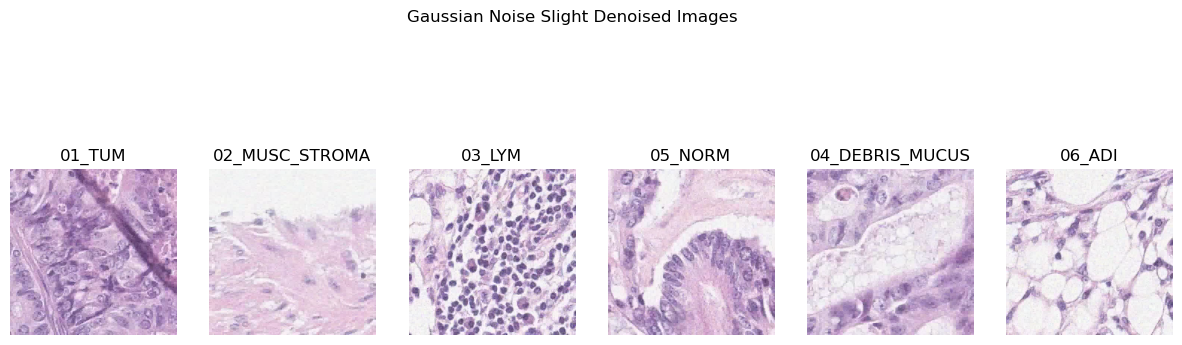

<Figure size 640x480 with 0 Axes>

In [8]:
denoise_img_slight, denoise_img_severe = [], []
denoise_img_slight = [denoise_wavelet(image, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft') for image in noise_img_list_sli]

fig, axes = plt.subplots(1, len(denoise_img_slight), figsize=(15, 5))
fig.suptitle("Gaussian Noise Slight Denoised Images")
plt.figure(facecolor='white')
for i, ax in enumerate(axes):
    ax.imshow(denoise_img_slight[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
plt.savefig('./gaussian noise slight denoised.jpg')
plt.show()

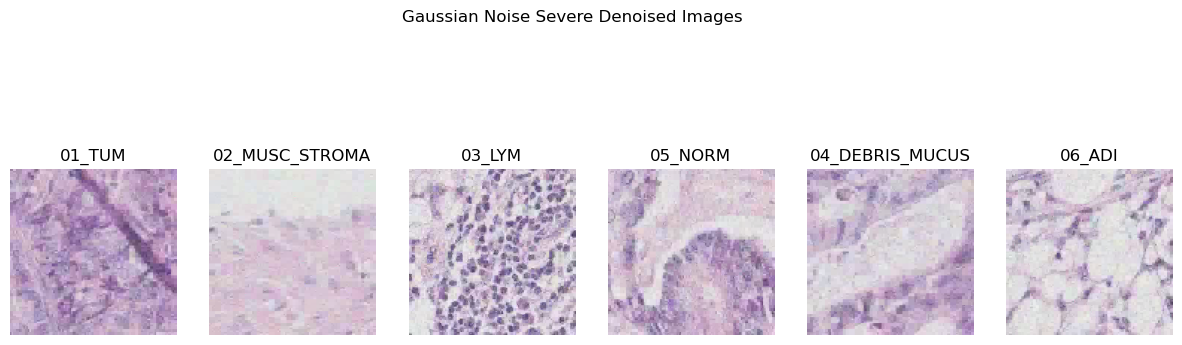

In [9]:
denoise_img_severe = [denoise_wavelet(image, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft') for image in noise_img_list_ser]

fig, axes = plt.subplots(1, len(denoise_img_slight), figsize=(15, 5))
fig.suptitle("Gaussian Noise Severe Denoised Images")
for i, ax in enumerate(axes):
    ax.imshow(denoise_img_severe[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
plt.savefig('./gaussian noise severe denoised.jpg')
plt.show()

Severe Image with calibrated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


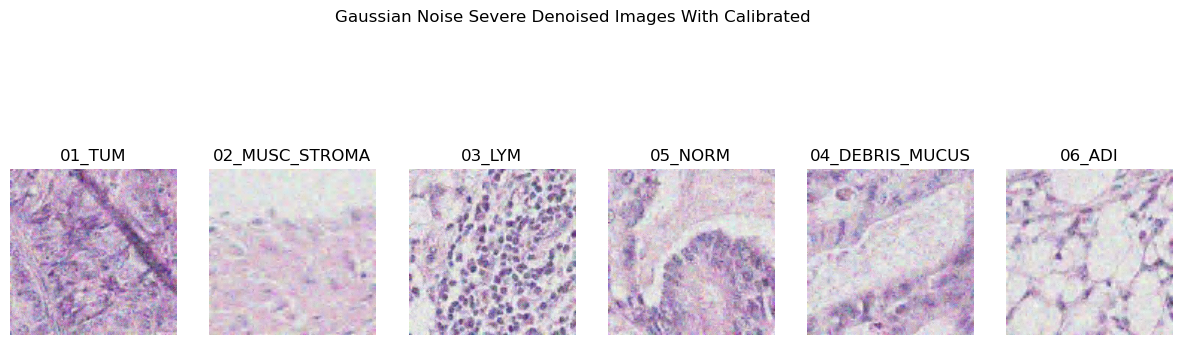

In [10]:
parameter_ranges = {
    'sigma': np.arange(0.1, 0.3, 0.02),
    'wavelet': ['db1', 'db2'],
    'convert2ycbcr': [True, False],
    'channel_axis': [-1],
}

calibrated_severe_img_list_temp = [calibrated := calibrate_denoiser(image, denoise_function=denoise_wavelet, denoise_parameters=parameter_ranges) for image in noise_img_list_ser]
calibrated_severe_img_list = [calibrated(image) for image in noise_img_list_ser]

fig, axes = plt.subplots(1, len(denoise_img_slight), figsize=(15, 5))
fig.suptitle("Gaussian Noise Severe Denoised Images With Calibrated")
for i, ax in enumerate(axes):
    ax.imshow(calibrated_severe_img_list[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
plt.savefig('./gaussian noise severe denoised with calibrated.jpg')
plt.show()

Shift-invariant wavelet denoising

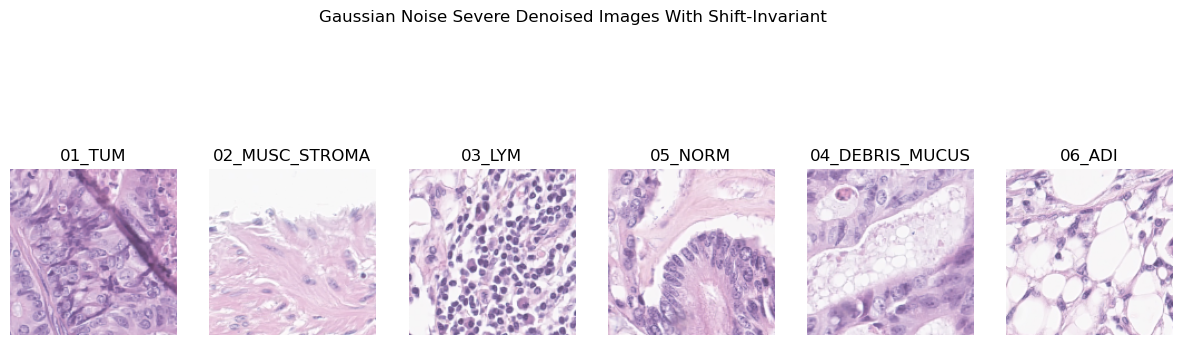

In [12]:
denoise_kwargs = dict(
    channel_axis=-1, convert2ycbcr=True, wavelet='db1', rescale_sigma=True
)
shifts = 3
shift_denoised_img = [shift_invariant := cycle_spin(
    image,
    func = denoise_wavelet,
    max_shifts = 3,
    func_kw = denoise_kwargs,
    channel_axis = -1
) for image in image_list]
# shift_denoised_img = [shift_invariant]

fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
fig.suptitle("Gaussian Noise Severe Denoised Images With Shift-Invariant")
for i, ax in enumerate(axes):
    ax.imshow(shift_denoised_img[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
plt.savefig('./gaussian noise severe denoised with shift-invariant.jpg')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


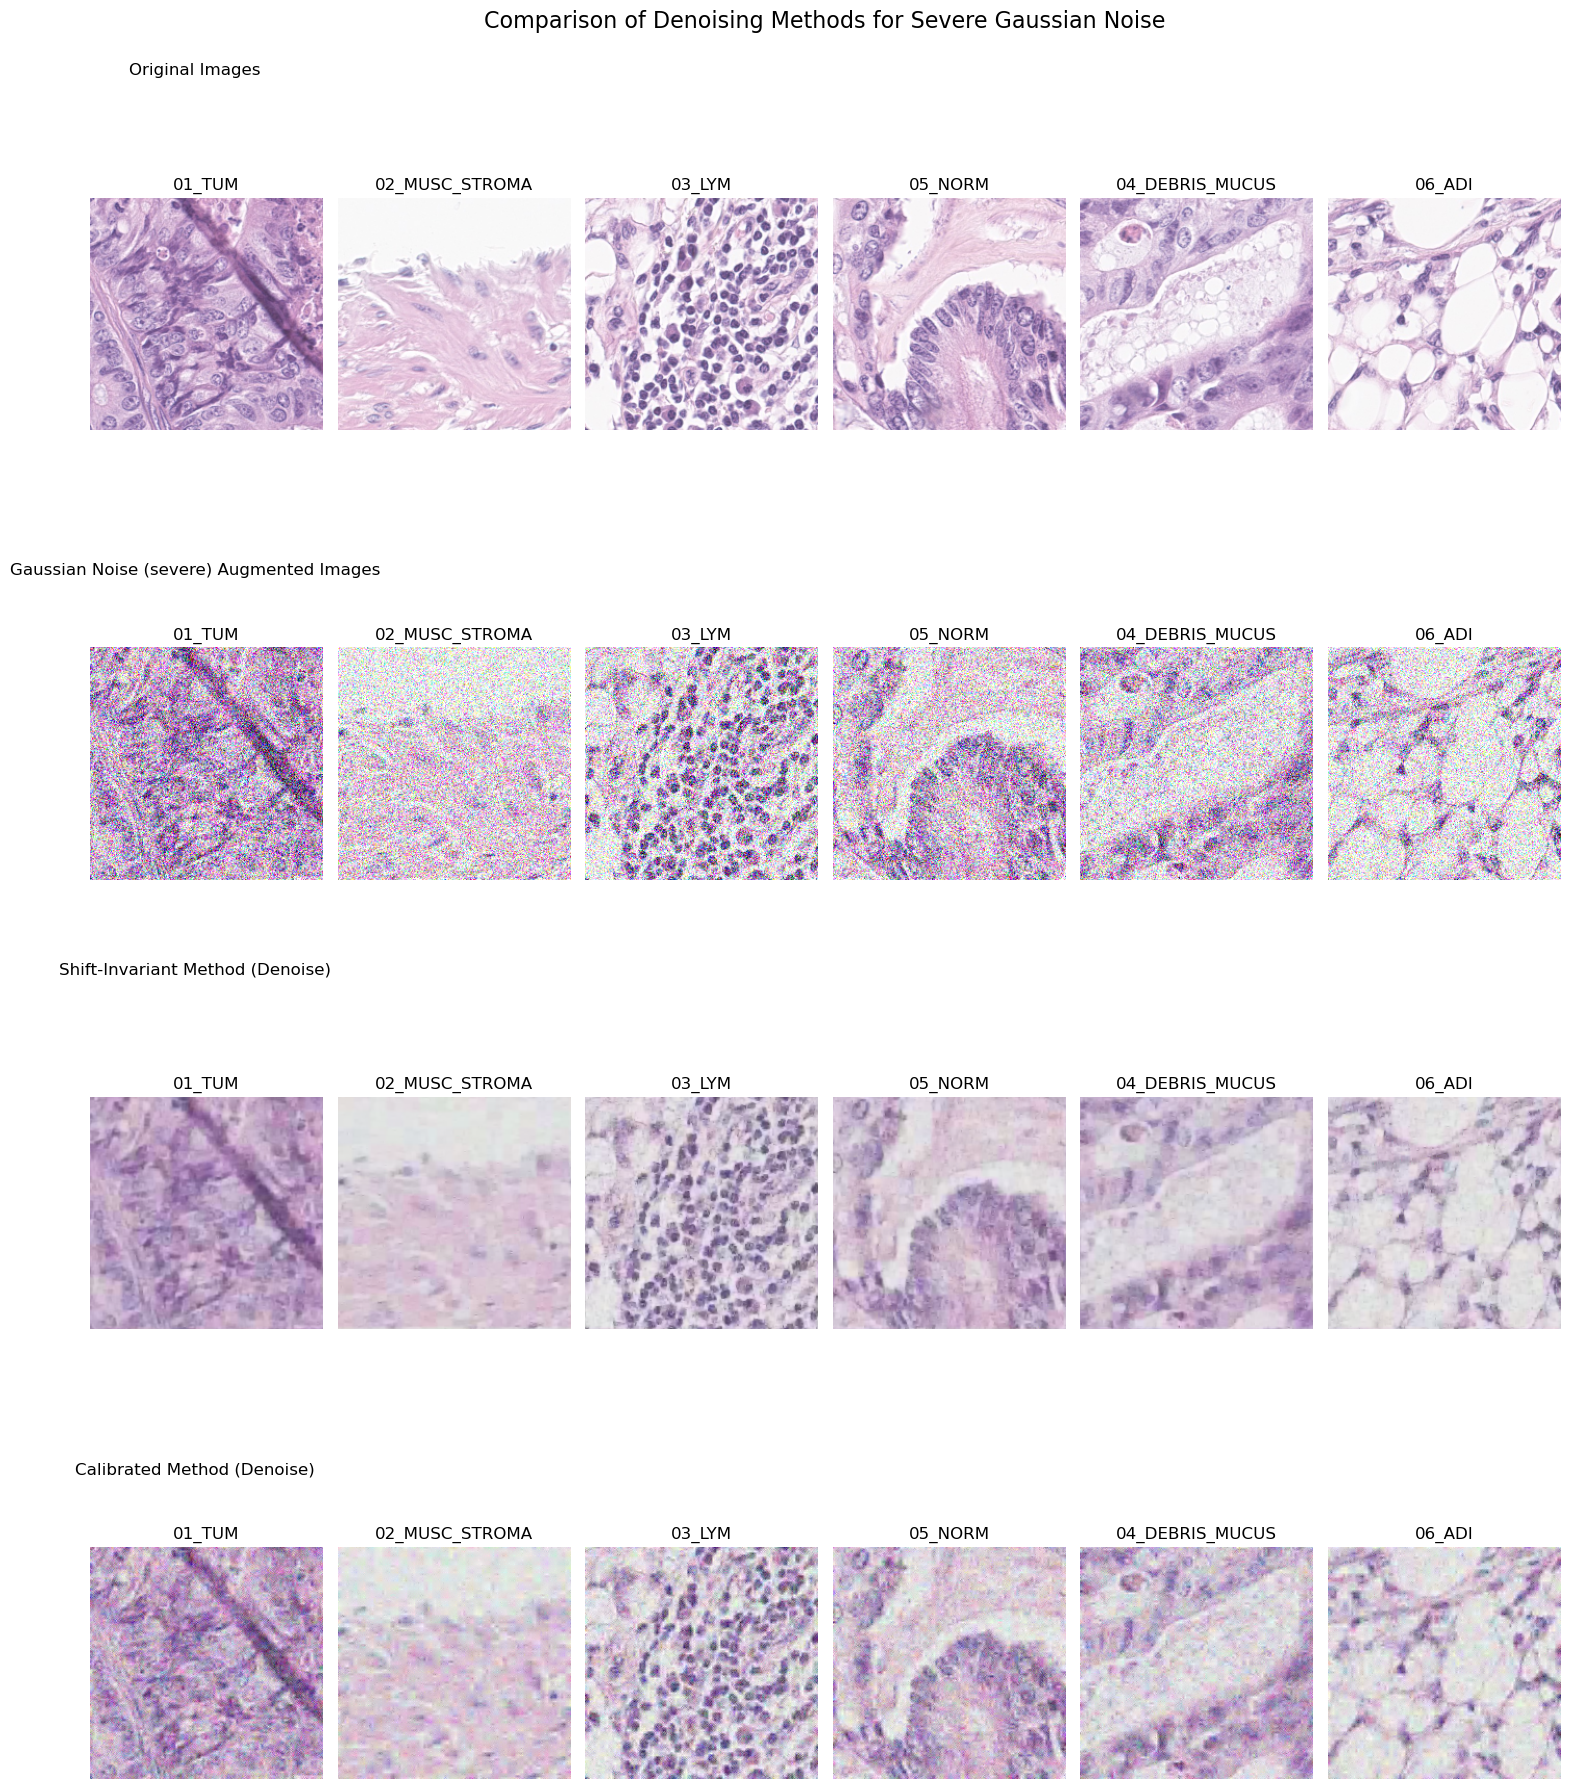

In [12]:
fig, axes = plt.subplots(4, len(denoise_img_slight), figsize=(15, 20))
fig.suptitle("Comparison of Denoising Methods for Severe Gaussian Noise", fontsize=16)

for i, ax in enumerate(axes[0]):
    ax.imshow(image_list[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])

fig.text(0.08, 0.95, "Original Images", horizontalalignment='center',
         verticalalignment='center', fontsize=12)
# plt.title('original image')
# plt.savefig('./original image.jpg')
# plt.show()

for i, ax in enumerate(axes[1]):
    ax.imshow(noise_img_list_ser[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
# plt.savefig('./severe gaussian noise.jpg')
# plt.show()

fig.text(0.08, 0.7, "Gaussian Noise (severe) Augmented Images", horizontalalignment='center',
         verticalalignment='center', fontsize=12)

for i, ax in enumerate(axes[2]):
    ax.imshow(shift_denoised_img[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])
# plt.savefig('./gaussian noise severe denoised with shift-invariant.jpg')
# plt.show()
fig.text(0.08, 0.5, "Shift-Invariant Method (Denoise)", horizontalalignment='center',
         verticalalignment='center', fontsize=12)

# fig, axes = plt.subplots(1, len(denoise_img_slight), figsize=(15, 5))
for i, ax in enumerate(axes[3]):
    ax.imshow(calibrated_severe_img_list[i])
    ax.axis('off')  # Hide the axes
    ax.set_title(image_name[i].split('/')[-2])

fig.text(0.08, 0.25, "Calibrated Method (Denoise)", horizontalalignment='center',
         verticalalignment='center', fontsize=12)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.savefig('./result.jpg')
plt.show()